#Tutorial: Conditional Generative Adversarial Network (cGAN)
##Resolution Enhancement

* Author: James Harding
* email: jamesharding@live.co.uk | james.harding@ed.ac.uk
* License: MIT
* Repository: Github

---

##Notebook Summary
Given a subset of low-res and high-res satellite data, this notebook develops a simple c-GAN to enhance the images resolution. The training data contains 3500 cloudless image samples (3500:3500 clouds:noclouds). This set is split into Train:Val:Test sets using 80:0:20% of the data.

##Code Cell Contents:

A. Preamble

B. Dataset Pre-processing

C. Model Development

D. Results


#Preamble

This cell handles authentication for Google services and mounts Google Drive in the notebook:


In [7]:
#@title 1. Authentication – Colab & Google Drive

# Cloud/colab authentication.
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code snippet sets up the environment for a Google Colab notebook by installing necessary external libraries and importing various Python packages. It ensures all required tools are available for data manipulation, visualization, and model building with TensorFlow.

In [23]:
#@title 2. Libraries, Definitions & Packages

# External library installations
!pip install patool imageio git+https://github.com/tensorflow/docs

# Standard library imports
import os
import glob
import time
import pathlib

# Third-party library imports for data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import imageio
import PIL.Image

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# TensorFlow additional tools and datasets
import tensorflow_datasets as tfds

# Utility for working with archives
import patoolib

# Check TensorFlow version
print(tf.__version__)


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-yyv0r8ks
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-yyv0r8ks
  Resolved https://github.com/tensorflow/docs to commit 9efadf0a84eae76e347787e344626650ea4ed85b
  Preparing metadata (setup.py) ... done
2.15.0


#Dataset

In [24]:
#@title Dataset Splits – Train:Validation:Test 80:0:20%

import pathlib
import numpy as np
import tensorflow as tf

# Set the directory path to the dataset
data_dir = pathlib.Path("/content/drive/MyDrive/toy_data/clouds")

# Load image files from the 'noclouds' subdirectory
images_path = data_dir.glob('noclouds/*.png')
image_count = len(list(images_path))
print(f'Total image count: {image_count}')

# Create a dataset of filenames for images in 'noclouds'
list_ds = tf.data.Dataset.list_files(str(data_dir/'noclouds/*.png'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

# Retrieve class names, excluding any 'LICENSE.txt'
class_names = np.array([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f'Class names: {class_names}')

# Count and display the number of images in each class
for class_name in class_names:
    class_path = data_dir.glob(f'{class_name}/*.png')
    class_count = len(list(class_path))
    print(f'Count for {class_name}: {class_count}')

# Define dataset splits
test_size = int(image_count * 0.2)
train_ds = list_ds.skip(test_size)
test_ds = list_ds.take(test_size)

# Output counts for training and test datasets
print(f'Total sample count: {image_count}')
print(f'Training sample count: {tf.data.experimental.cardinality(train_ds).numpy()}')
print(f'Test sample count: {tf.data.experimental.cardinality(test_ds).numpy()}')


Total image count: 3500
Class names: ['clouds' 'noclouds']
Count for clouds: 3500
Count for noclouds: 3500
Total sample count: 3500
Training sample count: 2800
Test sample count: 700


In [25]:
#@title Pre-processing

import tensorflow as tf
import os

# Constants
batch_size = 32
img_height = 200
img_width = 200
AUTOTUNE = tf.data.AUTOTUNE

def decode_img(img, size):
    """Decode and preprocess image."""
    img = tf.io.decode_jpeg(img, channels=3)  # Decode JPEG image to 3D tensor
    img = tf.image.resize(img, size)          # Resize to target size
    return (img / 127.5) - 1                 # Normalize to [-1, 1]

def random_rotate_image(img):
    """Randomly rotate the image by 0, 90, 180, or 270 degrees."""
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    return tf.image.rot90(img, k)

def process_path(file_path):
    """Process the file path into a downsampled input and original resolution output."""
    img = tf.io.read_file(file_path)                               # Read image file
    img = decode_img(img, [img_height, img_width])                 # Decode and resize
    img = random_rotate_image(img)                                 # Random rotation
    img = tf.image.random_flip_left_right(img)                     # Random horizontal flip
    img = tf.image.random_flip_up_down(img)                        # Random vertical flip
    img = tf.image.resize(img, [img_height + 16, img_width + 16])  # Resize to slightly larger
    low_res_img = tf.image.resize(img, [216//3, 216//3])           # Downsample for input
    return low_res_img, img                                        # Return input and label

def configure_for_performance(ds):
    """Configure dataset for performance."""
    ds = ds.batch(batch_size, drop_remainder=True)  # Batch dataset
    ds = ds.prefetch(buffer_size=AUTOTUNE)          # Prefetch for performance
    return ds

# Map the processing function to dataset and configure for performance
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)


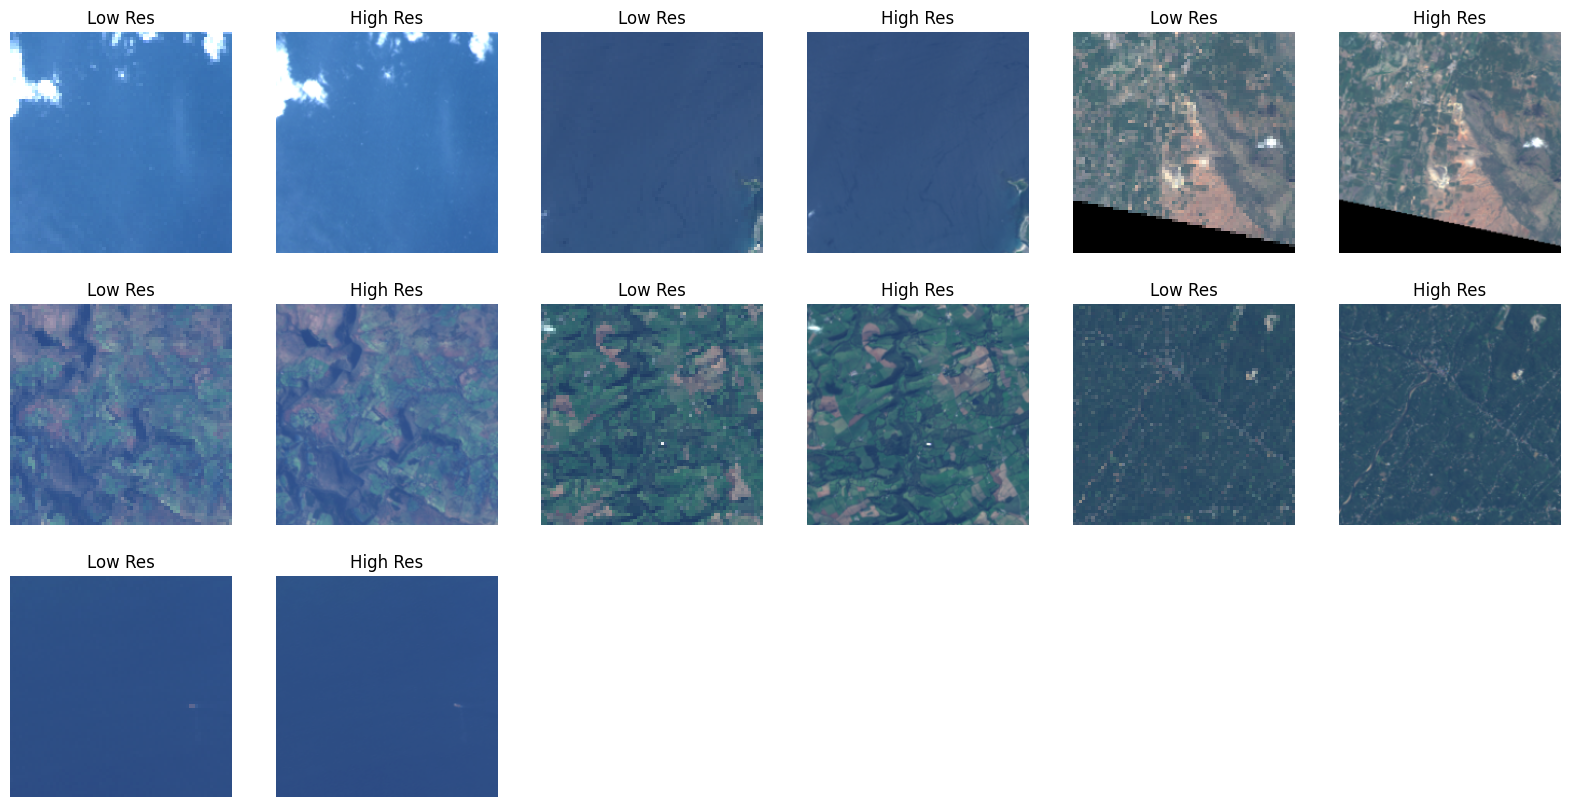

In [26]:
#@title Visualising

import matplotlib.pyplot as plt

def visualize_super_resolution(image_batch, label_batch):
    """Visualize a batch of low and high resolution images."""
    plt.figure(figsize=(20, 10))
    for i in range(7):  # Display 7 pairs of images
        # Display low-resolution images
        ax = plt.subplot(3, 6, 2*i+1)
        plt.imshow(image_batch[i].numpy() * 0.5 + 0.5)  # Adjust normalization
        plt.title("Low Res")
        plt.axis("off")

        # Display high-resolution images
        ax = plt.subplot(3, 6, 2*i+2)
        plt.imshow(label_batch[i].numpy() * 0.5 + 0.5)  # Adjust normalization
        plt.title("High Res")
        plt.axis("off")

    plt.show()  # Display the figure

# Fetch a single batch and visualize the super-resolution results
for low_res_image_batch, high_res_image_batch in train_ds.take(1):
    visualize_super_resolution(low_res_image_batch, high_res_image_batch)



#Model

In [27]:
#@title Callbacks

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk

class EarlyStoppingAtMinLoss(tfk.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=10):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        print("Loading best weights")
        self.model.set_weights(self.best_weights)
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [28]:
#@title 10. Generator & Discriminator

import tensorflow as tf
from tensorflow.keras import layers, Model

dim = 216
def make_generator_model():
    # Input: Low-res image
    low_res_input = tf.keras.Input(shape=(dim//3, dim//3, 3))
    low_res = layers.BatchNormalization()(low_res_input)

    # Replace Conv2DTranspose with UpSampling2D + Conv2D
    low_res = layers.UpSampling2D(size=(3, 3), interpolation='bilinear')(low_res)  # Upsample
    low_res = layers.Conv2D(216, (3, 3), strides=(1, 1), padding='same', activation='swish', use_bias=False)(low_res)  # Convolution
    low_res = layers.BatchNormalization()(low_res)


    # Input: Seed (random noise)
    noise_input = tf.keras.Input(shape=(100))
    noise = layers.Dense(((dim//3)**2)*216,use_bias=False,)(noise_input)
    noise = layers.Reshape(((dim//3), (dim//3), 216))(noise)
    noise = layers.BatchNormalization()(noise)
    noise = layers.UpSampling2D(size=(3, 3), interpolation='bilinear')(noise)  # Upsample
    noise = layers.Conv2D(216, (3, 3), strides=(1, 1), padding='same', activation='swish', use_bias=False)(noise)  # Convolution
    noise = layers.BatchNormalization()(noise)

    # Concatenate inputs
    x = layers.Concatenate()([low_res, noise])


    # Adjusting the architecture to account for 'valid' padding might require rethinking the layer parameters
    # Here's a simplified continuation assuming 'valid' padding

    x = layers.Conv2D(216, (3, 3), strides=(3, 3), padding='same', activation='swish',use_bias=True)(x)
    #x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size=(3, 3), interpolation='bilinear')(x)  # Upsample
    x = layers.Conv2D(72, (3, 3), strides=(3, 3), padding='same', activation='swish',use_bias=True)(x)
    #x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size=(3, 3), interpolation='bilinear')(x)  # Upsample
    x = layers.Conv2D(24, (3, 3), strides=(3, 3), padding='same', activation='swish',use_bias=True)(x)
    x = layers.UpSampling2D(size=(3, 3), interpolation='bilinear')(x)  # Upsample
    x = layers.Conv2D(6, (3, 3), strides=(3, 3), padding='same', activation='swish',use_bias=True)(x)
    x = layers.UpSampling2D(size=(3, 3), interpolation='bilinear')(x)  # Upsample
    #x = layers.BatchNormalization()(x)
    x = layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh',use_bias=True)(x)

    # Create model
    model = Model(inputs=[low_res_input, noise_input], outputs=x)

    return model


# Create the generator model
generator = make_generator_model()

# Model summary to verify architecture
generator.summary()

def make_discriminator_model():
    # Input for high-resolution images
    high_res_input = tf.keras.Input(shape=[dim, dim, 3], name='high_res_input')
    high_res = layers.BatchNormalization()(high_res_input)

    # Input for low-resolution images
    low_res_input = tf.keras.Input(shape=[dim//3, dim//3, 3], name='low_res_input')
    low_res = layers.BatchNormalization()(low_res_input)
    low_res = layers.UpSampling2D(size=(3, 3), interpolation='bilinear')(low_res)  # Upsample

    # Concatenate upsampled low-res input with high-res input
    x = layers.Concatenate()([low_res, high_res])
    x = layers.Conv2D(216, (3, 3), strides=(1, 1), padding='same', activation='swish',use_bias=True)(x)
    x = layers.Conv2D(128, (3, 3), strides=(3, 3), padding='same', activation='swish',use_bias=True)(x)
    x = layers.Conv2D(24, (3, 3), strides=(3, 3), padding='same', activation='swish',use_bias=True)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)  # Output layer

    # Create the model
    model = Model(inputs=[low_res_input, high_res_input], outputs=output)

    return model


# Instantiate and review the discriminator model
discriminator = make_discriminator_model()
discriminator.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 1119744)              1119744   ['input_6[0][0]']             
                                                          00                                      
                                                                                                  
 input_5 (InputLayer)        [(None, 72, 72, 3)]          0         []                            
                                                                                                  
 reshape_2 (Reshape)         (None, 72, 72, 216)          0         ['dense_4[0][0]']       

In [29]:
#@title Losses

import os

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def mean_squared_error_loss(generated_images, real_images):
    return tf.reduce_mean(tf.abs(generated_images - real_images))

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generator_loss(fake_output, generated_images, real_images, lambda_mse=10):
    # Original GAN loss
    gan_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    # MSE loss
    mse_loss = mean_squared_error_loss(generated_images, real_images)
    # Total generator loss
    total_gen_loss = gan_loss + lambda_mse * mse_loss
    return total_gen_loss



def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

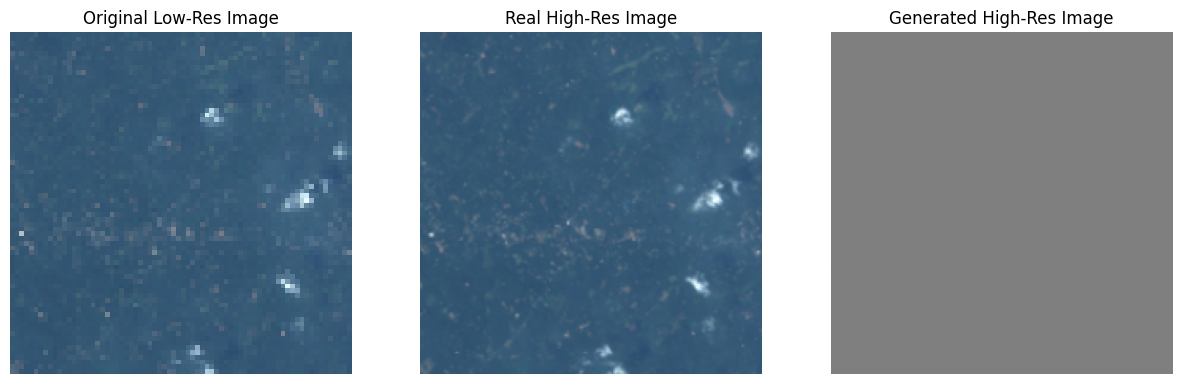

In [30]:
import matplotlib.pyplot as plt
import tensorflow as tf

for low_res_img, high_res_img in train_ds.take(1):
    break  # `low_res_img` now contains one batch of low-resolution images

# Ensure the noise batch size matches the low-res image batch size
batch_size = low_res_img.shape[0]  # This should be 1 based on how you're taking data from test_ds

for step in range(100):
    # Now, both `low_res_img` and `noise` have matching batch sizes
    generated_image = generator([low_res_img, tf.random.normal([batch_size, 100])], training=False)
    real_output = discriminator([low_res_img, high_res_img], training=True)
    fake_output = discriminator([low_res_img, generated_image], training=True)

# Plotting
plt.figure(figsize=(15, 5))

# Plot original low-resolution image
plt.subplot(1, 3, 1)
plt.imshow(low_res_img[0] * 0.5 + 0.5)
plt.title("Original Low-Res Image")
plt.axis("off")

# Plot real high-resolution image
plt.subplot(1, 3, 2)
plt.imshow(high_res_img[0] * 0.5 + 0.5)  # assuming real_hr_img is already loaded and preprocessed
plt.title("Real High-Res Image")
plt.axis("off")

# Plot generated high-resolution image
plt.subplot(1, 3, 3)
# Adjusting the pixel values to be in the [0, 1] range for plotting
plt.imshow((generated_image[0] * 0.5 + 0.5))
plt.title("Generated High-Res Image")
plt.axis("off")

plt.show()

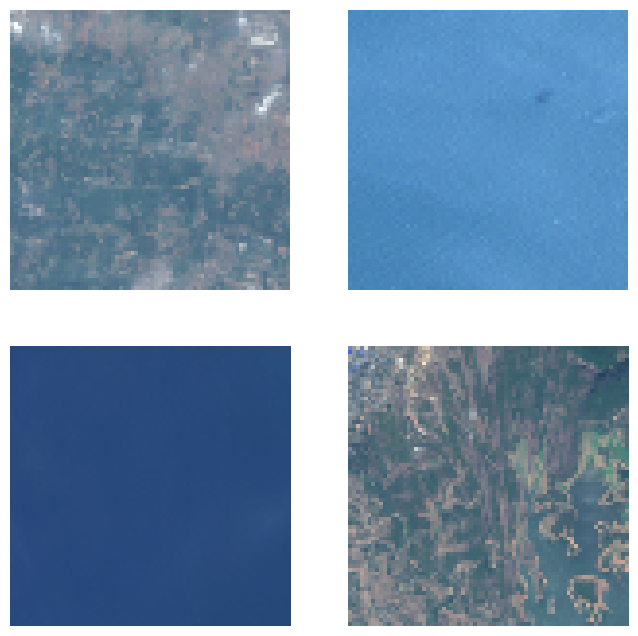

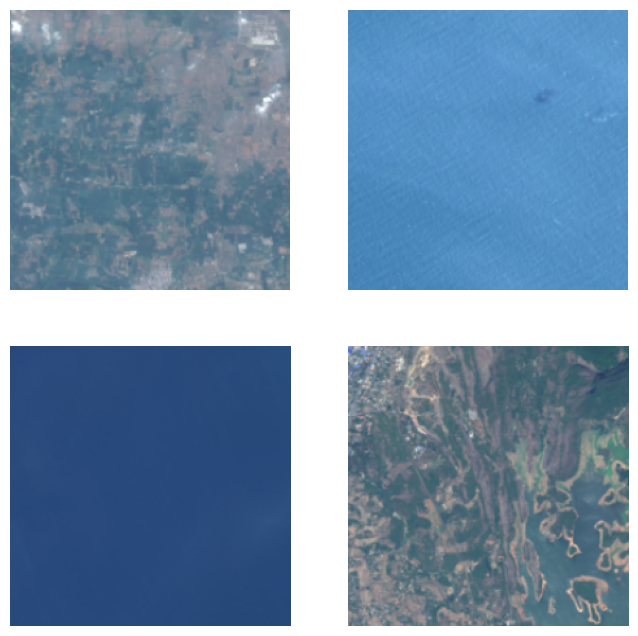

In [31]:
#@title Inputs & Targets

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
import time

# Take 4 examples for visualization, capturing both low-res and high-res images
fixed_low_res_imgs = []
fixed_high_res_imgs = []  # List to store high-res images
for low_res_example, high_res_example in train_ds.take(4):
    fixed_low_res_imgs.append(low_res_example)
    fixed_high_res_imgs.append(high_res_example)

# Convert lists to tensors
fixed_low_res_imgs = tf.concat(fixed_low_res_imgs, axis=0)
fixed_high_res_imgs = tf.concat(fixed_high_res_imgs, axis=0)

# Generate 4 fixed noise seeds
fixed_noises = tf.random.normal([fixed_low_res_imgs.shape[0], 100])  # Adjusted for 4 examples

import matplotlib.pyplot as plt

def plot_original_high_res_images(fixed_high_res_imgs):
    fig = plt.figure(figsize=(8, 8))  # Adjusted size for better visualization

    for i in range(4):
        plt.subplot(2, 2, i+1)  # Adjusted for a 2x2 grid
        plt.imshow((fixed_high_res_imgs[i, :, :, :] * 0.5 + 0.5))  # Normalize if needed
        plt.axis('off')

    plt.show()

def generate_and_save_images(model, epoch, fixed_low_res_imgs, fixed_noises):
    predictions = model([fixed_low_res_imgs, fixed_noises], training=False)

    fig = plt.figure(figsize=(8, 8))  # Adjusted size for better visualization

    for i in range(4):
        plt.subplot(2, 2, i+1)  # Adjusted for a 2x2 grid
        plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))  # Assuming the output is in [-1, 1]
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

plot_original_high_res_images(fixed_low_res_imgs)

plot_original_high_res_images(fixed_high_res_imgs)


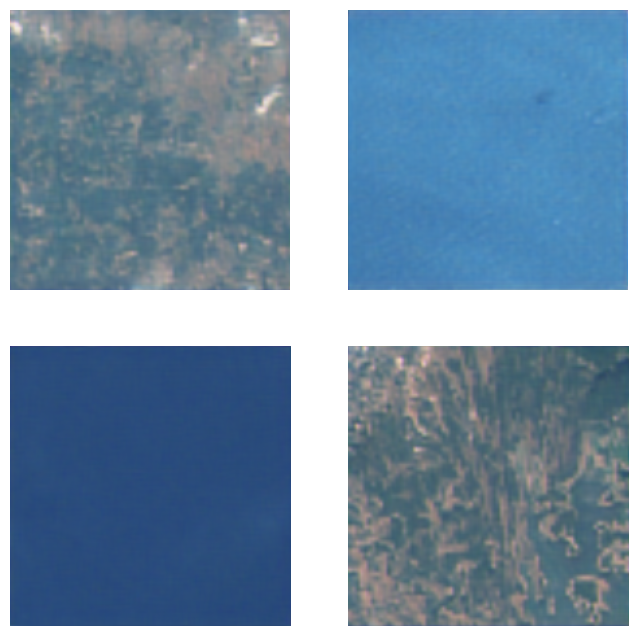

Time for epoch 7 is 27.46 sec
Generator loss = 1.5979, Discriminator loss = 1.1495


In [ ]:
#@title Training

# Set TensorFlow to use float64 as the default float type
tf.keras.backend.set_floatx('float32')

# Verify the current default float type
print('Default float type:', tf.keras.backend.floatx())
import tensorflow as tf
import time
from IPython import display

# Define training step
@tf.function
def train_step(images):
    low_res_img, high_res_img = images
    high_res_img = tf.cast(high_res_img, tf.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        noise = tf.random.normal([batch_size, 100])
        generated_images = generator([low_res_img, noise], training=True)

        real_output = discriminator([low_res_img, high_res_img], training=True)
        fake_output = discriminator([low_res_img, generated_images], training=True)

        gen_loss = generator_loss(fake_output, generated_images, high_res_img)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Define training process
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        # Display and save images
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, fixed_low_res_imgs, fixed_noises)

        # Print losses and timing
        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')
        print(f'Generator loss = {gen_loss_avg:.4f}, Discriminator loss = {disc_loss_avg:.4f}')

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, fixed_low_res_imgs, fixed_noises)

# Training the model
train(train_ds, 15)


#Results

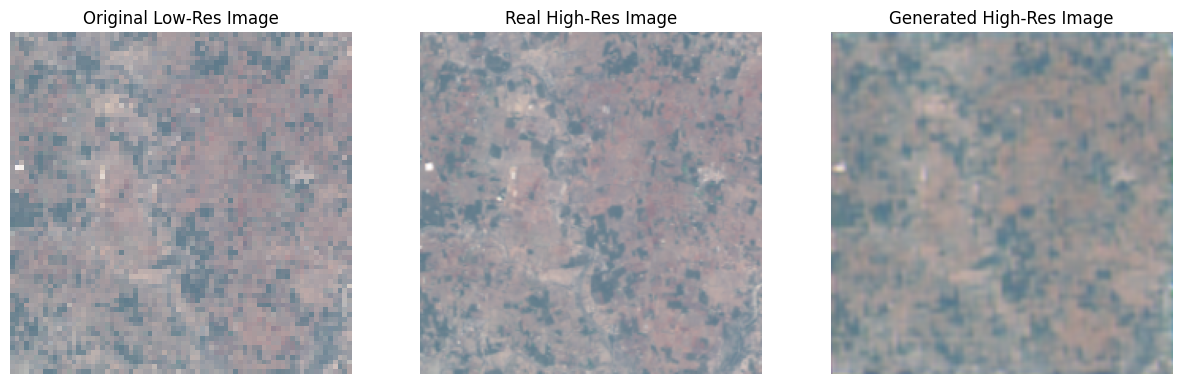

In [33]:
#@title Qualitative Validation

import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming `test_ds` is properly batched with a batch size of 1
for low_res_img, high_res_img in test_ds.take(1):
    break  # `low_res_img` now contains one batch of low-resolution images

# Ensure the noise batch size matches the low-res image batch size
batch_size = low_res_img.shape[0]  # This should be 1 based on how you're taking data from test_ds

# Generate a fake high-resolution image using the generator
generated_image = generator([low_res_img, tf.random.normal([batch_size, 100])], training=False)

# Plotting
plt.figure(figsize=(15, 5))

# Plot original low-resolution image
plt.subplot(1, 3, 1)
plt.imshow(low_res_img[0] * 0.5 + 0.5)
plt.title("Original Low-Res Image")
plt.axis("off")

# Plot real high-resolution image
plt.subplot(1, 3, 2)
plt.imshow(high_res_img[0] * 0.5 + 0.5)  # assuming real_hr_img is already loaded and preprocessed
plt.title("Real High-Res Image")
plt.axis("off")

# Plot generated high-resolution image
plt.subplot(1, 3, 3)
# Adjusting the pixel values to be in the [0, 1] range for plotting
plt.imshow((generated_image[0] * 0.5 + 0.5))
plt.title("Generated High-Res Image")
plt.axis("off")

plt.show()


In [34]:
import glob
import imageio

# Path to the animation file
anim_file = 'cgan.gif'

# Create a GIF writer with imageio to save the animation
with imageio.get_writer(anim_file, mode='I') as writer:
    # Gather and sort filenames that match the 'image*.png' pattern
    filenames = sorted(glob.glob('image*.png'))

    # Iterate over each file in the sorted list
    for filename in filenames:
        # Try to read and append each image to the GIF
        try:
            image = imageio.imread(filename)
            writer.append_data(image)
        except Exception as e:
            # If an error occurs, print the error and skip to the next image
            print(f"Error processing {filename}: {e}")
            continue


<ipython-input-34-373bb1b0ab33>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-34-373bb1b0ab33>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



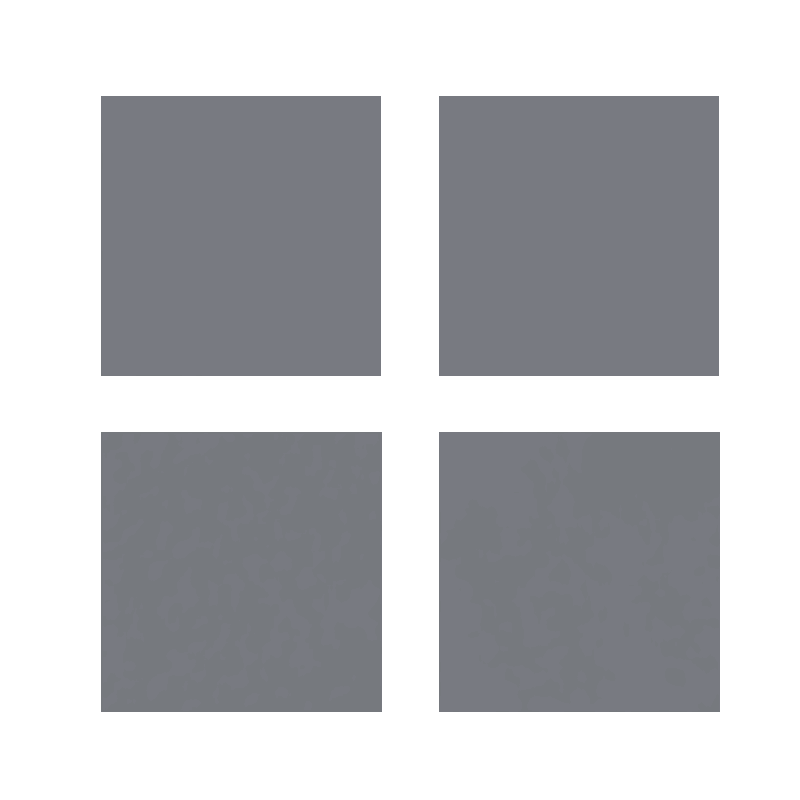

In [35]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [36]:
#@title 12. Model Saving
model_save_path = "/content/drive/MyDrive/tutorials/model"
model.save(model_save_path)

loaded = tfk.models.load_model(model_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

NameError: name 'model' is not defined